**Personal Finance Analytics Project**   
Objective: Analyze spending behavior, compare budget vs actuals, and build an expense prediction model.

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

In [135]:
transactions = pd.read_csv('../data/personal_transactions.csv')
budget = pd.read_csv('../data/Budget.csv')

Understand and Cleaning of Data

In [136]:
#First 5 transactions
transactions.head()

,Date,Description,Amount,Transaction Type,Category,Account Name
0,01/01/2018,Amazon,11.11,debit,Shopping,Platinum Card
1,01/02/2018,Mortgage Payment,1247.44,debit,Mortgage & Rent,Checking
2,01/02/2018,Thai Restaurant,24.22,debit,Restaurants,Silver Card
3,01/03/2018,Credit Card Payment,2298.09,credit,Credit Card Payment,Platinum Card
4,01/04/2018,Netflix,11.76,debit,Movies & DVDs,Platinum Card


In [137]:
transactions.shape

(806, 6)

In [138]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 806 entries, 0 to 805
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              806 non-null    object 
 1   Description       806 non-null    object 
 2   Amount            806 non-null    float64
 3   Transaction Type  806 non-null    object 
 4   Category          806 non-null    object 
 5   Account Name      806 non-null    object 
dtypes: float64(1), object(5)
memory usage: 37.9+ KB


In [139]:
transactions.columns = transactions.columns.str.strip().str.lower().str.replace(" ", "_")
transactions.columns

Index(['date', 'description', 'amount', 'transaction_type', 'category',
       'account_name'],
      dtype='object')

In [140]:
transactions['date'] = pd.to_datetime(transactions['date'])
transactions['date'].dtype

dtype('<M8[ns]')

In [141]:
transactions['amount'] = transactions['amount'].astype(float)

transactions.loc[transactions['transaction_type'].str.lower() == 'debit', 'amount'] *= -1

In [142]:
transactions.isnull().sum()

date                0
description         0
amount              0
transaction_type    0
category            0
account_name        0
dtype: int64

In [143]:
#only if we have missing value in category column
transactions['category'] = transactions['category'].fillna('Unknown')

Feature Engineering

In [144]:
transactions['expense'] = transactions['amount'].apply(lambda x: -x if x < 0 else 0)
transactions['income'] = transactions['amount'].apply(lambda x: x if x > 0 else 0)

In [145]:
transactions['year'] = transactions['date'].dt.year
transactions['month'] = transactions['date'].dt.month
transactions['month_name'] = transactions['date'].dt.month_name()
transactions['year_month'] = transactions['date'].dt.to_period('M')

In [146]:
monthly_summary = transactions.groupby(['year', 'month', 'month_name']).agg(
    total_expense=('expense', 'sum'),
    total_income=('income', 'sum')
).reset_index()

monthly_summary['savings'] = monthly_summary['total_income'] - monthly_summary['total_expense']
monthly_summary

,year,month,month_name,total_expense,total_income,savings
0,2018,1,January,2931.45,7162.89,4231.44
1,2018,2,February,3165.05,5220.75,2055.70
2,2018,3,March,3500.16,7321.50,3821.34
3,2018,4,April,6029.54,7166.88,1137.34
4,2018,5,May,11392.03,5091.55,-6300.48
5,2018,6,June,3665.88,6017.19,2351.31
6,2018,7,July,2968.98,4666.34,1697.36
7,2018,8,August,2396.18,7379.15,4982.97
8,2018,9,September,3286.99,5234.71,1947.72
9,2018,10,October,2848.35,5022.23,2173.88


In [147]:
monthly_data = transactions.groupby(['year', 'month']).agg(
    total_expense=('expense', 'sum'),
    total_income=('income', 'sum')
).reset_index()

monthly_data['date'] = pd.to_datetime(monthly_data[['year', 'month']].assign(day=1))
monthly_data = monthly_data.sort_values('date')

monthly_data.head()

,year,month,total_expense,total_income,date
0,2018,1,2931.45,7162.89,2018-01-01
1,2018,2,3165.05,5220.75,2018-02-01
2,2018,3,3500.16,7321.50,2018-03-01
3,2018,4,6029.54,7166.88,2018-04-01
4,2018,5,11392.03,5091.55,2018-05-01


EDA (Exploratory Data Analysis)

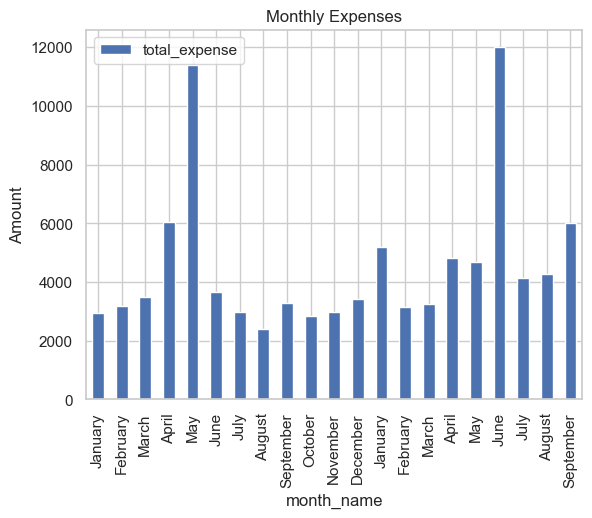

In [148]:
import matplotlib.pyplot as plt

monthly_summary.plot(x='month_name', y='total_expense', kind='bar')
plt.title('Monthly Expenses')
plt.ylabel('Amount')
plt.show()

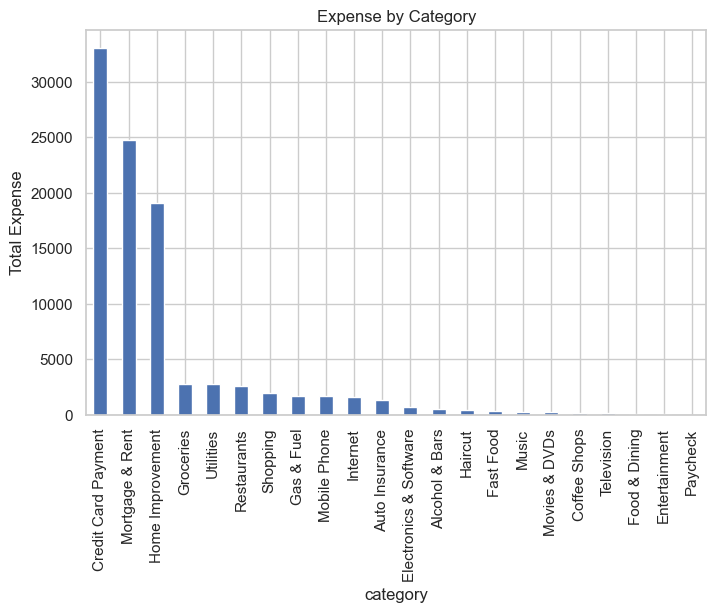

In [149]:
category_summary = transactions.groupby('category')['expense'].sum().sort_values(ascending=False)

plt.figure(figsize=(8,5))
category_summary.plot(kind='bar')
plt.title("Expense by Category")
plt.ylabel("Total Expense")
plt.show()

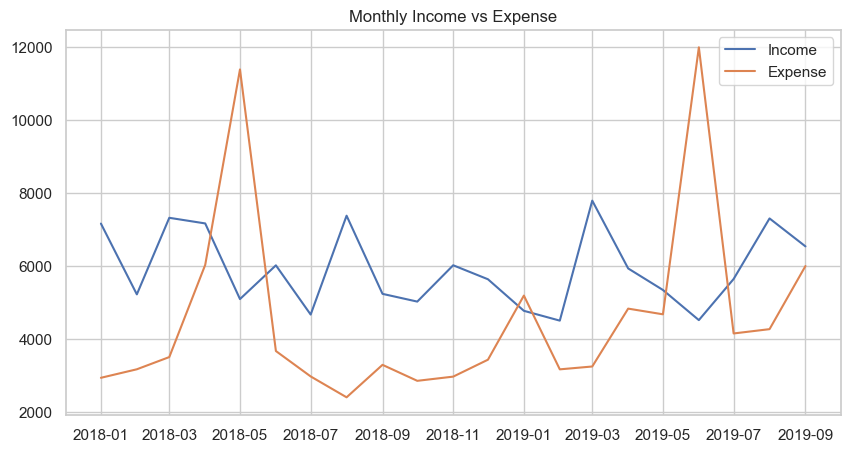

In [150]:
plt.figure(figsize=(10,5))
plt.plot(monthly_data['date'], monthly_data['total_income'], label='Income')
plt.plot(monthly_data['date'], monthly_data['total_expense'], label='Expense')
plt.legend()
plt.title("Monthly Income vs Expense")
plt.show()

In [151]:
monthly_data.sort_values('total_expense', ascending=False).head(5)

,year,month,total_expense,total_income,date
17,2019,6,11999.60,4514.35,2019-06-01
4,2018,5,11392.03,5091.55,2018-05-01
3,2018,4,6029.54,7166.88,2018-04-01
20,2019,9,5998.42,6537.06,2019-09-01
12,2019,1,5187.31,4769.44,2019-01-01


Budget vs Actual Analysis

In [152]:
budget.head()

,Category,Budget
0,Alcohol & Bars,50
1,Auto Insurance,75
2,Coffee Shops,15
3,Electronics & Software,0
4,Entertainment,25


In [153]:
budget.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  19 non-null     object
 1   Budget    19 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 436.0+ bytes


In [154]:
budget.columns = budget.columns.str.strip().str.lower()

In [155]:
monthly_category_expense = transactions.groupby(
    ['year', 'month', 'month_name', 'category']
).agg(
    actual_expense=('expense', 'sum')
).reset_index()

monthly_category_expense.head()

,year,month,month_name,category,actual_expense
0,2018,1,January,Coffee Shops,3.00
1,2018,1,January,Credit Card Payment,864.80
2,2018,1,January,Fast Food,32.91
3,2018,1,January,Gas & Fuel,65.29
4,2018,1,January,Groceries,87.73


In [156]:
monthly_budget_vs_actual = pd.merge(
    monthly_category_expense,
    budget,
    on='category',
    how='left'
)

In [157]:
monthly_budget_vs_actual['budget'] = monthly_budget_vs_actual['budget'].fillna(0)

In [158]:
monthly_budget_vs_actual['variance'] = (
    monthly_budget_vs_actual['budget'] - monthly_budget_vs_actual['actual_expense']
)

In [159]:
monthly_budget_vs_actual

,year,month,month_name,category,actual_expense,budget,variance
0,2018,1,January,Coffee Shops,3.00,15.0,12.00
1,2018,1,January,Credit Card Payment,864.80,0.0,-864.80
2,2018,1,January,Fast Food,32.91,15.0,-17.91
3,2018,1,January,Gas & Fuel,65.29,75.0,9.71
4,2018,1,January,Groceries,87.73,150.0,62.27
...,...,...,...,...,...,...,...
335,2019,9,September,Paycheck,0.00,0.0,0.00
336,2019,9,September,Restaurants,172.34,150.0,-22.34
337,2019,9,September,Shopping,85.38,100.0,14.62
338,2019,9,September,Television,13.90,15.0,1.10


In [160]:
jan_data = monthly_budget_vs_actual[
    monthly_budget_vs_actual['month_name'] == 'January'
]

In [161]:
jan_data[['category', 'actual_expense', 'budget']].head(10)

,category,actual_expense,budget
0,Coffee Shops,3.00,15.0
1,Credit Card Payment,864.80,0.0
2,Fast Food,32.91,15.0
3,Gas & Fuel,65.29,75.0
4,Groceries,87.73,150.0
5,Home Improvement,51.21,250.0
6,Internet,69.99,75.0
7,Mobile Phone,89.46,65.0
8,Mortgage & Rent,1247.44,1100.0
9,Movies & DVDs,11.76,0.0


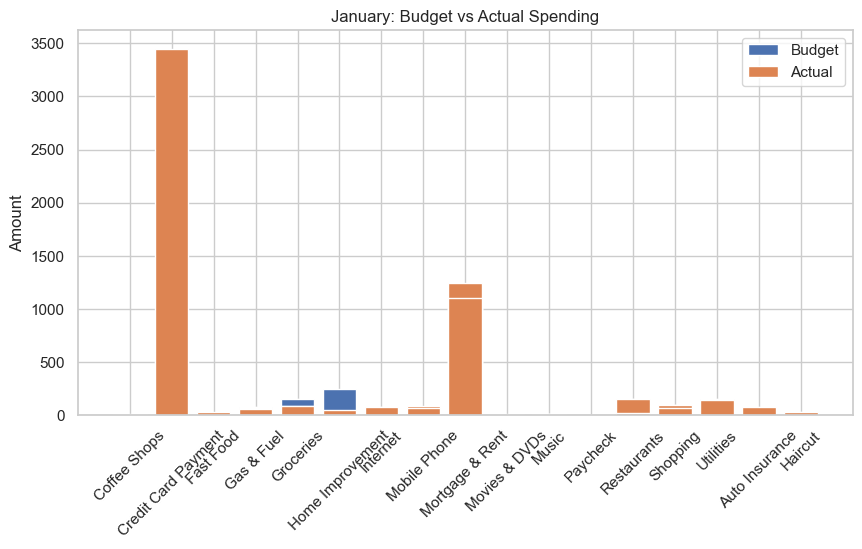

In [162]:
plt.figure(figsize=(10,5))

plt.bar(jan_data['category'], jan_data['budget'], label='Budget')
plt.bar(jan_data['category'], jan_data['actual_expense'], label='Actual')

plt.title('January: Budget vs Actual Spending')
plt.ylabel('Amount')
plt.xticks(rotation=45)
plt.legend()
plt.show()

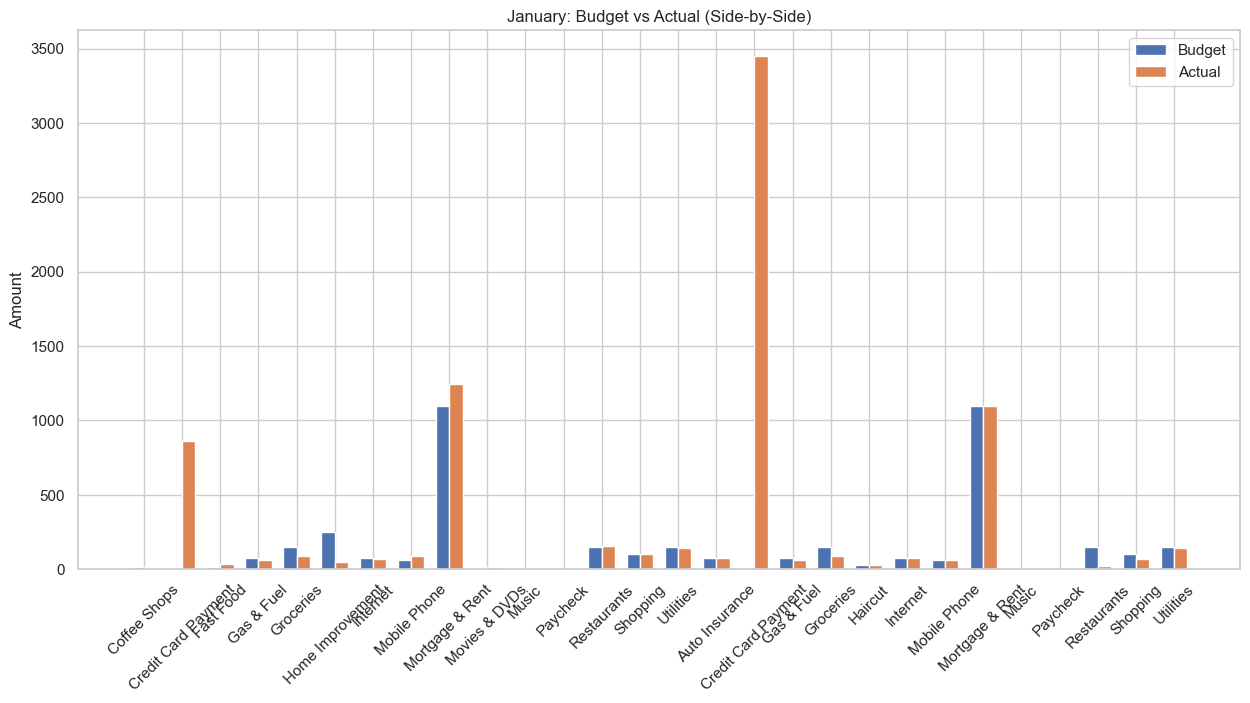

In [163]:
import numpy as np

x = np.arange(len(jan_data))
width = 0.35

plt.figure(figsize=(15,7))
plt.bar(x - width/2, jan_data['budget'], width, label='Budget')
plt.bar(x + width/2, jan_data['actual_expense'], width, label='Actual')

plt.xticks(x, jan_data['category'], rotation=45)
plt.ylabel('Amount')
plt.title('January: Budget vs Actual (Side-by-Side)')
plt.legend()
plt.show()


In [164]:
monthly_summary.to_csv('../data/monthly_summary.csv', index=False)

In [165]:
monthly_budget_vs_actual.to_csv(
    '../data/monthly_budget_vs_actual.csv',
    index=False
)

In [166]:
transactions.to_csv('../data/clean_transactions.csv', index=False)

In [167]:
monthly_data = transactions.groupby(['year', 'month']).agg(
    total_expense=('expense', 'sum'),
    total_income=('income', 'sum')
).reset_index()

monthly_data['date'] = pd.to_datetime(monthly_data[['year', 'month']].assign(day=1))

monthly_data = monthly_data.sort_values('date')
monthly_data.head()

,year,month,total_expense,total_income,date
0,2018,1,2931.45,7162.89,2018-01-01
1,2018,2,3165.05,5220.75,2018-02-01
2,2018,3,3500.16,7321.50,2018-03-01
3,2018,4,6029.54,7166.88,2018-04-01
4,2018,5,11392.03,5091.55,2018-05-01


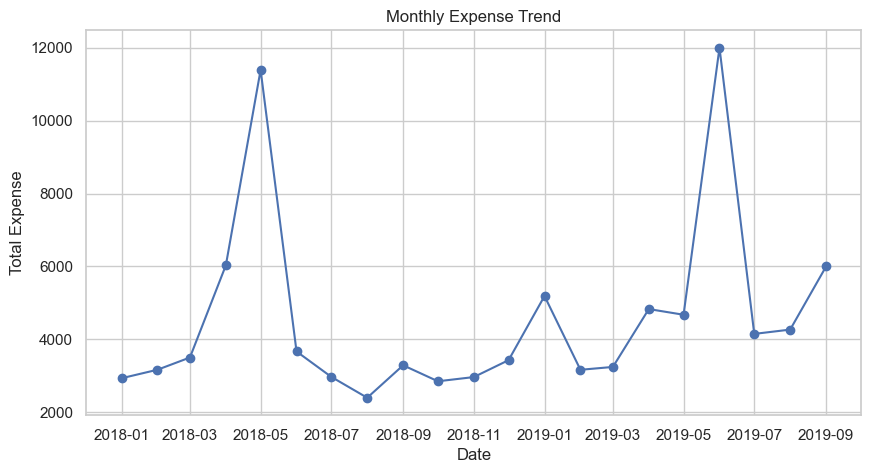

In [168]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(monthly_data['date'], monthly_data['total_expense'], marker='o')
plt.title("Monthly Expense Trend")
plt.xlabel("Date")
plt.ylabel("Total Expense")
plt.show()

Time Series Forecasting with ARIMA/SARIMA

In [169]:
from statsmodels.tsa.arima.model import ARIMA

ts_expense = monthly_data.set_index('date')['total_expense']

train_size = int(len(ts_expense) * 0.8)
train = ts_expense[:train_size]
test = ts_expense[train_size:]

In [170]:
arima_model = ARIMA(
    train,
    order=(1,1,1)   # ARIMA parameters
)

arima_result = arima_model.fit()

C:\Users\ayush\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ayush\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ayush\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ayush\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [171]:
arima_predictions = arima_result.predict(start=test.index[0], end=test.index[-1])
arima_predictions

2019-05-01    4164.113148
2019-06-01    3923.408614
2019-07-01    3836.339987
2019-08-01    3804.845168
2019-09-01    3793.452734
Freq: MS, Name: predicted_mean, dtype: float64

In [172]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

arima_mae = mean_absolute_error(test, arima_predictions)
arima_rmse = np.sqrt(mean_squared_error(test, arima_predictions))
arima_mape = np.mean(np.abs((test - arima_predictions) / test)) * 100

arima_accuracy = 100 - arima_mape

print("ARIMA MAE:", arima_mae)
print("ARIMA RMSE:", arima_rmse)
print("ARIMA MAPE:", arima_mape)
print("Accuracy (%):", arima_accuracy)

ARIMA MAE: 2312.7200696552713
ARIMA RMSE: 3759.1547738452637
ARIMA MAPE: 26.658206801260626
Accuracy (%): 73.34179319873937


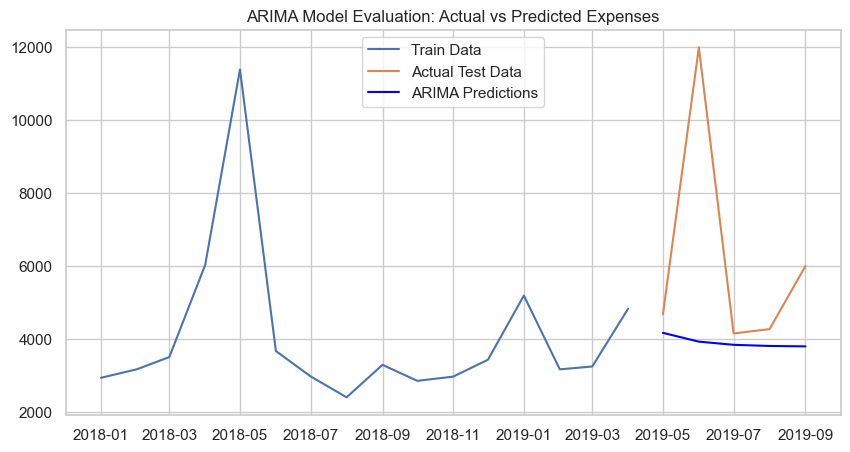

In [173]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(train.index, train, label="Train Data")
plt.plot(test.index, test, label="Actual Test Data")
plt.plot(test.index, arima_predictions, label="ARIMA Predictions", color='blue')
plt.legend()
plt.title("ARIMA Model Evaluation: Actual vs Predicted Expenses")
plt.show()

In [174]:
final_arima_model = ARIMA(
    ts_expense,
    order=(1,1,1)
)

final_arima_result = final_arima_model.fit()

future_arima_forecast = final_arima_result.forecast(steps=6)
future_arima_forecast

C:\Users\ayush\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ayush\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ayush\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


2019-10-01    4739.991146
2019-11-01    4448.159228
2019-12-01    4380.482881
2020-01-01    4364.788614
2020-02-01    4361.149086
2020-03-01    4360.305072
Freq: MS, Name: predicted_mean, dtype: float64

In [175]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

ts_expense = monthly_data.set_index('date')['total_expense']

train_size = int(len(ts_expense) * 0.8)
train = ts_expense[:train_size]
test = ts_expense[train_size:]

In [176]:
sarima_model = SARIMAX(
    train,
    order=(1,1,1),           # ARIMA part
    seasonal_order=(1,1,1,12) # SARIMA part (12 = monthly seasonality)
)

sarima_result = sarima_model.fit()

C:\Users\ayush\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ayush\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ayush\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\ayush\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'

In [177]:
sarima_predictions = sarima_result.predict(start=test.index[0], end=test.index[-1])
sarima_predictions

2019-05-01    6162.971151
2019-06-01    4012.490118
2019-07-01    3345.110317
2019-08-01    3278.694714
2019-09-01    3472.249958
Freq: MS, Name: predicted_mean, dtype: float64

In [178]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

sarima_mae = mean_absolute_error(test, sarima_predictions)
sarima_rmse = np.sqrt(mean_squared_error(test, sarima_predictions))
sarima_mape = np.mean(np.abs((test - sarima_predictions) / test)) * 100

sarima_accuracy = 100 - mape

print("SARIMA MAE:", mae)
print("SARIMA RMSE:", rmse)
print("SARIMA MAPE:", mape)
print("Accuracy (%):", accuracy)

SARIMA MAE: 2758.6332086596517
SARIMA RMSE: 3847.4352367637885
SARIMA MAPE: 36.609912278353626
Accuracy (%): 63.390087721646374


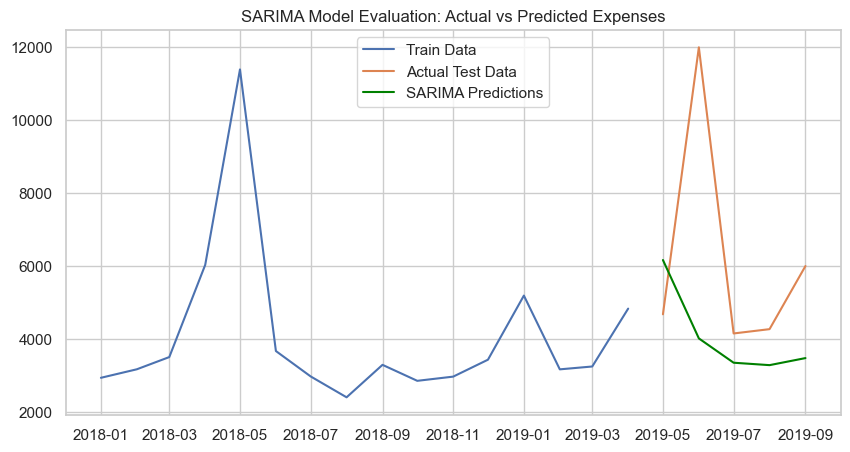

In [179]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(train.index, train, label="Train Data")
plt.plot(test.index, test, label="Actual Test Data")
plt.plot(test.index, sarima_predictions, label="SARIMA Predictions", color='green')
plt.legend()
plt.title("SARIMA Model Evaluation: Actual vs Predicted Expenses")
plt.show()

In [180]:
final_sarima_model = SARIMAX(
    ts_expense,
    order=(1,1,1),
    seasonal_order=(1,1,1,12)
)

final_sarima_result = final_sarima_model.fit()

future_forecast = final_sarima_result.forecast(steps=6)
future_forecast

C:\Users\ayush\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ayush\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ayush\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\ayush\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2019-10-01    4784.693530
2019-11-01    4923.806543
2019-12-01    4246.234917
2020-01-01    7518.080118
2020-02-01    6795.158420
2020-03-01    7047.347779
Freq: MS, Name: predicted_mean, dtype: float64

In [181]:
results = pd.DataFrame({
    'Model': ['ARIMA', 'SARIMA'],
    'MAPE': [arima_mape, sarima_mape],
    'RMSE': [arima_rmse, sarima_rmse]
})

results

,Model,MAPE,RMSE
0,ARIMA,26.658207,3759.154774
1,SARIMA,36.609912,3847.435237


In [182]:
arima_residuals = arima_result.resid
sarima_residuals = sarima_result.resid

In [183]:
residual_df = pd.DataFrame({
    'Actual': ts_expense,
    'ARIMA_Residual': arima_residuals,
    'SARIMA_Residual': sarima_residuals
})

print(residual_df.head())

              Actual  ARIMA_Residual  SARIMA_Residual
date                                                 
2018-01-01   2931.45     2931.450000      2931.450000
2018-02-01   3165.05     1053.326992       989.189699
2018-03-01   3500.16     1038.053916       255.188646
2018-04-01   6029.54     3236.998927      2639.186830
2018-05-01  11392.03     7141.576283      6062.084642


In [184]:
arima_pred = arima_result.predict(start=0, end=len(ts_expense)-1)
sarima_pred = sarima_result.predict(start=0, end=len(ts_expense)-1)

In [185]:
arima_residuals_manual = ts_expense - arima_pred
sarima_residuals_manual = ts_expense - sarima_pred

print(arima_residuals_manual.head())
print(sarima_residuals_manual.head())

date
2018-01-01    2931.450000
2018-02-01    1053.326992
2018-03-01    1038.053916
2018-04-01    3236.998927
2018-05-01    7141.576283
dtype: float64
date
2018-01-01    2931.450000
2018-02-01     989.189699
2018-03-01     255.188646
2018-04-01    2639.186830
2018-05-01    6062.084642
dtype: float64


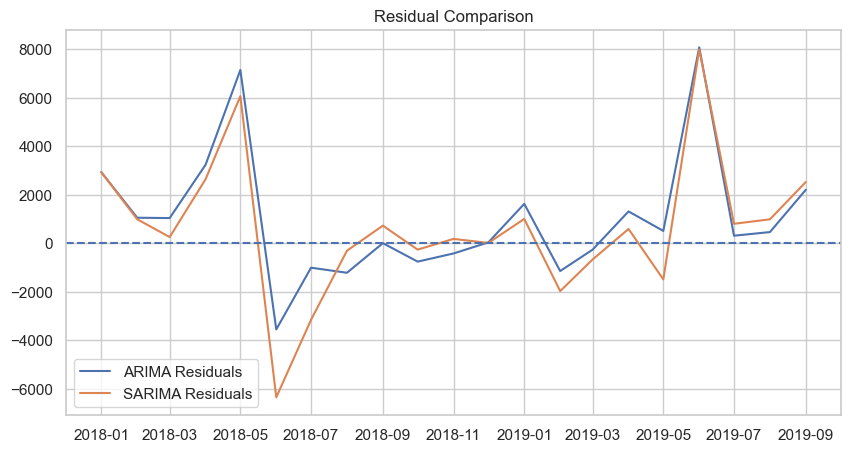

In [186]:
plt.figure(figsize=(10,5))
plt.plot(arima_residuals_manual, label="ARIMA Residuals")
plt.plot(sarima_residuals_manual, label="SARIMA Residuals")
plt.axhline(0, linestyle='--')
plt.legend()
plt.title("Residual Comparison")
plt.show()

Anomaly Detection

In [187]:
from sklearn.ensemble import IsolationForest

iso_model = IsolationForest(contamination=0.1, random_state=42)

monthly_data['anomaly'] = iso_model.fit_predict(monthly_data[['total_expense']])

In [188]:
anomaly_months = monthly_data[monthly_data['anomaly'] == -1]
anomaly_months[['date', 'total_expense']]

,date,total_expense
4,2018-05-01,11392.03
17,2019-06-01,11999.60


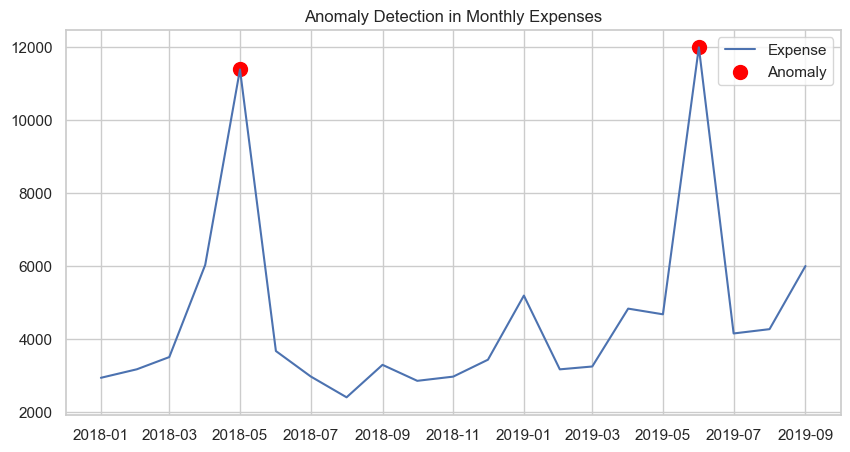

In [189]:
plt.figure(figsize=(10,5))
plt.plot(monthly_data['date'], monthly_data['total_expense'], label="Expense")

plt.scatter(
    anomaly_months['date'],
    anomaly_months['total_expense'],
    color='red',
    label='Anomaly',
    s=100
)

plt.legend()
plt.title("Anomaly Detection in Monthly Expenses")
plt.show()